# GRAPHSAGE-T Debugging for Baseline Dataset

This notebook is just for debugging the baseline dataset.

## Imports & Config

In [1]:
import os
import json
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

try:
    from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("sklearn not available -> only basic metrics will be printed.")

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_DIR = r"C:\Users\yasmi\OneDrive\Desktop\Uni - Master's\Fall 2025\MLR 570\Motif-Aware-Temporal-GNNs-for-Anti-Money-Laundering-Detection\ibm_transcations_datasets\pyg_graph_hismall_base"

PyTorch: 2.5.1+cu121
CUDA available: True


## Load Tensors

In [2]:
edge_index = torch.load(os.path.join(DATA_DIR, "edge_index.pt"))
x = torch.load(os.path.join(DATA_DIR, "x.pt"))
edge_attr = torch.load(os.path.join(DATA_DIR, "edge_attr.pt"))
timestamps = torch.load(os.path.join(DATA_DIR, "timestamps.pt"))
y_edge = torch.load(os.path.join(DATA_DIR, "y_edge.pt"))
y_node = torch.load(os.path.join(DATA_DIR, "y_node.pt"))

print("edge_index:", edge_index.shape, edge_index.dtype)
print("x:", x.shape, x.dtype)
print("edge_attr:", edge_attr.shape, edge_attr.dtype)
print("timestamps:", timestamps.shape, timestamps.dtype)
print("y_edge:", y_edge.shape, y_edge.dtype)
print("y_node:", y_node.shape, y_node.dtype)

num_nodes = x.shape[0]
num_edges = edge_index.shape[1]

pos_edges = int(y_edge.sum().item())
print(f"#nodes: {num_nodes:,}")
print(f"#edges: {num_edges:,}")
print(f"Positive laundering edges: {pos_edges:,} ({pos_edges / num_edges * 100:.4f}%)")
print(f"Positive laundering nodes: {int(y_node.sum().item()):,}")


edge_index: torch.Size([2, 5078345]) torch.int64
x: torch.Size([518573, 4]) torch.float32
edge_attr: torch.Size([5078345, 1]) torch.float32
timestamps: torch.Size([5078345]) torch.int64
y_edge: torch.Size([5078345]) torch.int64
y_node: torch.Size([518573]) torch.int64
#nodes: 518,573
#edges: 5,078,345
Positive laundering edges: 5,177 (0.1019%)
Positive laundering nodes: 6,357


C:\Users\yasmi\AppData\Local\Temp\ipykernel_42252\2442908827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edge_index = torch.load(os.path.join(DATA_DIR, "edge_index.p

## Sanity Checks
Index ranges, NaNs, Basic Stats

In [3]:
print("Checking index ranges...")
src, dst = edge_index
print("  src min/max:", src.min().item(), src.max().item())
print("  dst min/max:", dst.min().item(), dst.max().item())
assert src.min() >= 0 and dst.min() >= 0
assert src.max() < num_nodes and dst.max() < num_nodes
print("Index ranges OK.")

def has_nan_or_inf(t: torch.Tensor, name: str):
    if torch.isnan(t).any():
        print(f"[WARN] {name} has NaNs")
    if torch.isinf(t).any():
        print(f"[WARN] {name} has Infs")

has_nan_or_inf(x, "x")
has_nan_or_inf(edge_attr, "edge_attr")

print("Edge attr (amount) stats:")
ea = edge_attr[:, 0].cpu().numpy()
print("  mean:", ea.mean(), "std:", ea.std(), "min:", ea.min(), "max:", ea.max())
print("Node feature stats per dim:")
xf = x.cpu().numpy()
for i in range(xf.shape[1]):
    print(f"  dim {i}: mean={xf[:, i].mean():.4f}, std={xf[:, i].std():.4f}, "
          f"min={xf[:, i].min():.4f}, max={xf[:, i].max():.4f}")


Checking index ranges...
  src min/max: 0 518572
  dst min/max: 0 518572
Index ranges OK.
Edge attr (amount) stats:
  mean: 1.1537962e-09 std: 1.0 min: -2.2008219 max: 6.013023
Node feature stats per dim:
  dim 0: mean=-0.0000, std=1.0000, min=-1.2595, max=4.2151
  dim 1: mean=0.0000, std=1.0000, min=-1.3709, max=9.7255
  dim 2: mean=0.0000, std=1.0000, min=-1.5808, max=3.6231
  dim 3: mean=0.0000, std=1.0000, min=-2.1696, max=4.4647


## Temporal Sanity Check

In [4]:
print("First 5 timestamps:", timestamps[:5])
print("Last 5 timestamps:", timestamps[-5:])

# Are timestamps sorted?
is_sorted = bool((timestamps[1:] >= timestamps[:-1]).all())
print("Timestamps sorted by edge order?", is_sorted)

# Convert some to human-readable
def to_dt(ts):
    return datetime.utcfromtimestamp(int(ts))

print("First datetime:", to_dt(int(timestamps[0])))
print("Last datetime:", to_dt(int(timestamps[-1])))


First 5 timestamps: tensor([1661990400, 1661990400, 1661990400, 1661990400, 1661990400])
Last 5 timestamps: tensor([1663495320, 1663499880, 1663499880, 1663505880, 1663517880])
Timestamps sorted by edge order? True
First datetime: 2022-09-01 00:00:00
Last datetime: 2022-09-18 16:18:00


## Class Imbalance & Simple Histograms

Negative edges: 5,073,168
Positive edges: 5,177


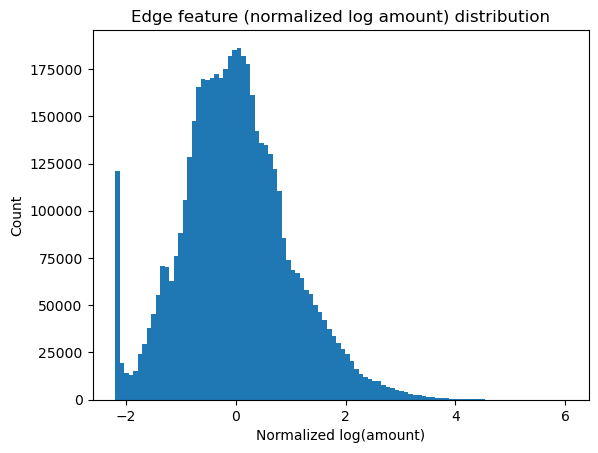

In [5]:
# Edge label distribution
y_np = y_edge.cpu().numpy()
neg = (y_np == 0).sum()
pos = (y_np == 1).sum()
print(f"Negative edges: {neg:,}")
print(f"Positive edges: {pos:,}")

plt.figure()
plt.hist(ea, bins=100)
plt.title("Edge feature (normalized log amount) distribution")
plt.xlabel("Normalized log(amount)")
plt.ylabel("Count")
plt.show()


## Simple Temporal Train/Val/Test Split (Edge-level)
We’ll do a time-based split similar to the RAT notebook:
70% earliest edges → train, 15% → val, 15% → test.

In [6]:
# Timestamps sanity
print("First 5 timestamps:", timestamps[:5])
print("Last 5 timestamps:", timestamps[-5:])

def to_dt(ts):
    return datetime.utcfromtimestamp(int(ts))

print("First datetime:", to_dt(int(timestamps[0])))
print("Last datetime:", to_dt(int(timestamps[-1])))

# Are they sorted by time?
is_sorted = bool((timestamps[1:] >= timestamps[:-1]).all())
print("Timestamps sorted by edge order?", is_sorted)

# --------------------------------------------------------
# Subset edges for debugging (like in RAT notebook)
# --------------------------------------------------------
MAX_EDGES = 1_000_000  # you can change this to 2_000_000 etc.

E_total = edge_index.size(1)
print("Total edges in full graph:", E_total)

E_sub = min(E_total, MAX_EDGES)
sub_idx = torch.arange(E_sub)

edge_index_sub = edge_index[:, sub_idx]
timestamps_sub = timestamps[sub_idx]
y_edge_sub = y_edge[sub_idx]

print(f"Using subset of {E_sub:,} edges for GraphSAGE-T debug.")

# --------------------------------------------------------
# Time-based split on the subset (sequential)
# --------------------------------------------------------
train_ratio = 0.7
val_ratio = 0.15
n_train = int(train_ratio * E_sub)
n_val = int(val_ratio * E_sub)
n_test = E_sub - n_train - n_val

train_idx = sub_idx[:n_train]
val_idx = sub_idx[n_train:n_train + n_val]
test_idx = sub_idx[n_train + n_val:]

print(f"Train edges: {len(train_idx):,}")
print(f"Val edges:   {len(val_idx):,}")
print(f"Test edges:  {len(test_idx):,}")

def label_stats(name, idx):
    y = y_edge[idx].cpu().numpy()
    pos = (y == 1).sum()
    total = len(y)
    print(f"{name}: pos={pos:,} ({pos/total*100:.4f}%), total={total:,}")

label_stats("Train", train_idx)
label_stats("Val", val_idx)
label_stats("Test", test_idx)


First 5 timestamps: tensor([1661990400, 1661990400, 1661990400, 1661990400, 1661990400])
Last 5 timestamps: tensor([1663495320, 1663499880, 1663499880, 1663505880, 1663517880])
First datetime: 2022-09-01 00:00:00
Last datetime: 2022-09-18 16:18:00
Timestamps sorted by edge order? True
Total edges in full graph: 5078345
Using subset of 1,000,000 edges for GraphSAGE-T debug.
Train edges: 700,000
Val edges:   150,000
Test edges:  150,000
Train: pos=157 (0.0224%), total=700,000
Val: pos=54 (0.0360%), total=150,000
Test: pos=67 (0.0447%), total=150,000


## Define GraphSAGE Model + Edge Classifier Head


In [7]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

# ------------------------------------------------------------
# GraphSAGE-T  (GraphSAGE + sinusoidal time encoding)
# ------------------------------------------------------------
class TimeEncode(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        # Frequencies (log-spaced), as in your RAT snippet
        self.w = nn.Parameter(torch.exp(
            torch.linspace(0, 3, dim)
        ), requires_grad=True)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """
        t: [E] or [*,] timestamps (float)
        returns: [E, dim] time encoding
        """
        # Normalize time to a smaller range (roughly days)
        t = t.float() / (60 * 60 * 24.0)  # seconds -> days
        t = t.unsqueeze(-1)               # [E, 1]
        # sinusoidal-style encoding: sin(w * t)
        out = torch.sin(self.w * t)       # [E, dim]
        return out


class GraphSAGE_T(nn.Module):
    def __init__(self, node_in_dim: int, time_dim: int, hidden_dim: int = 64, num_layers: int = 2):
        super().__init__()
        self.time_dim = time_dim
        self.time_encoder = TimeEncode(time_dim)

        self.convs = nn.ModuleList()
        in_dim = node_in_dim + time_dim

        # First SAGEConv
        self.convs.append(SAGEConv(in_dim, hidden_dim))

        # Additional layers (hidden -> hidden)
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.out_dim = hidden_dim

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, timestamps: torch.Tensor):
        """
        x: [N, node_in_dim]
        edge_index: [2, E_sub]
        timestamps: [E_sub]
        """
        N = x.size(0)
        E_sub = edge_index.size(1)
        src, dst = edge_index

        # Compute time encoding per edge
        t_enc = self.time_encoder(timestamps)  # [E_sub, time_dim]

        # Aggregate time encodings onto destination nodes (mean)
        T = torch.zeros(N, self.time_dim, device=x.device)
        T.index_add_(0, dst, t_enc)  # sum encodings by dst node

        deg = torch.bincount(dst, minlength=N).clamp(min=1).unsqueeze(-1)
        T = T / deg

        # Concatenate x and aggregated time encoding
        h = torch.cat([x, T], dim=1)  # [N, node_in_dim + time_dim]

        # Run GraphSAGE layers
        for conv in self.convs:
            h = conv(h, edge_index)
            h = torch.relu(h)

        return h  # node embeddings


c:\ProgramData\anaconda3\envs\aml_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Link Predictor Head + metrics
Here we add the edge-level classifier and evaluate() with the same metrics (loss, precision, recall, F1, ROC-AUC, AUPR).

In [8]:
hidden_dim = 64
time_dim = 32  # You can tune this, but keep same as RAT for comparability

class LinkPredictor(nn.Module):
    def __init__(self, node_in_dim, time_dim, hidden_dim=64):
        super().__init__()
        self.encoder = GraphSAGE_T(node_in_dim=node_in_dim,
                                   time_dim=time_dim,
                                   hidden_dim=hidden_dim,
                                   num_layers=2)
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x, edge_index, timestamps, edge_idx_subset):
        # Get node embeddings
        z = self.encoder(x, edge_index, timestamps)

        # Extract src & dst embeddings for chosen edges
        s, d = edge_index[0, edge_idx_subset], edge_index[1, edge_idx_subset]
        z_src = z[s]
        z_dst = z[d]
        z_pair = torch.cat([z_src, z_dst], dim=-1)

        logits = self.mlp(z_pair).squeeze(-1)  # [|subset|]
        return logits, z


model = LinkPredictor(
    node_in_dim=x.shape[1],
    time_dim=time_dim,
    hidden_dim=hidden_dim,
).to(device)

x = x.to(device)
edge_index_sub = edge_index_sub.to(device)
timestamps_sub = timestamps_sub.to(device)
y_edge_sub = y_edge_sub.to(device)
train_idx = train_idx.to(device)
val_idx = val_idx.to(device)
test_idx = test_idx.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCEWithLogitsLoss()

print(model)


LinkPredictor(
  (encoder): GraphSAGE_T(
    (time_encoder): TimeEncode()
    (convs): ModuleList(
      (0): SAGEConv(36, 64, aggr=mean)
      (1): SAGEConv(64, 64, aggr=mean)
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Evaluate function

In [9]:
import torch

def evaluate(split_idx):
    model.eval()
    with torch.no_grad():
        logits, _ = model(x, edge_index_sub, timestamps_sub, split_idx)
        y_true = y_edge_sub[split_idx].float()
        loss = loss_fn(logits, y_true).item()

        probs = torch.sigmoid(logits).cpu().numpy()
        y_np = y_true.cpu().numpy()
        preds = (probs >= 0.5).astype(np.int32)

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_np, preds, average="binary", zero_division=0
        )

        try:
            roc = roc_auc_score(y_np, probs)
        except ValueError:
            roc = float("nan")

        try:
            aupr = average_precision_score(y_np, probs)
        except ValueError:
            aupr = float("nan")

    return loss, prec, rec, f1, roc, aupr


## Training Loop

In [10]:
max_epochs = 10  # you can increase if it trains quickly

history = {
    "train_loss": [],
    "val_loss": [],
    "val_prec": [],
    "val_rec": [],
    "val_f1": [],
    "val_roc": [],
    "val_aupr": [],
}

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits, _ = model(x, edge_index_sub, timestamps_sub, train_idx)
    y_true = y_edge_sub[train_idx].float()
    loss = loss_fn(logits, y_true)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    history["train_loss"].append(train_loss)

    # validation
    val_loss, prec_v, rec_v, f1_v, roc_v, aupr_v = evaluate(val_idx)
    history["val_loss"].append(val_loss)
    history["val_prec"].append(prec_v)
    history["val_rec"].append(rec_v)
    history["val_f1"].append(f1_v)
    history["val_roc"].append(roc_v)
    history["val_aupr"].append(aupr_v)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f} "
        f"val_loss={val_loss:.4f} "
        f"P={prec_v:.3f} R={rec_v:.3f} F1={f1_v:.3f} "
        f"ROC-AUC={roc_v:.3f} AUPR={aupr_v:.3f}"
    )

# Final evaluation on val & test
print("\n=== FINAL VAL METRICS (subset) ===")
val_loss, prec_v, rec_v, f1_v, roc_v, aupr_v = evaluate(val_idx)
print(f"Val loss : {val_loss:.4f}")
print(f"Precision: {prec_v:.3f}")
print(f"Recall   : {rec_v:.3f}")
print(f"F1-score : {f1_v:.3f}")
print(f"ROC-AUC  : {roc_v:.3f}")
print(f"AUC-PR   : {aupr_v:.3f}")

print("\n=== FINAL TEST METRICS (subset) ===")
test_loss, prec_t, rec_t, f1_t, roc_t, aupr_t = evaluate(test_idx)
print(f"Test loss : {test_loss:.4f}")
print(f"Precision : {prec_t:.3f}")
print(f"Recall    : {rec_t:.3f}")
print(f"F1-score  : {f1_t:.3f}")
print(f"ROC-AUC   : {roc_t:.3f}")
print(f"AUC-PR    : {aupr_t:.3f}")


Epoch 01 | train_loss=0.7226 val_loss=0.6797 P=0.000 R=0.222 F1=0.001 ROC-AUC=0.474 AUPR=0.000
Epoch 02 | train_loss=0.6719 val_loss=0.6441 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.480 AUPR=0.000
Epoch 03 | train_loss=0.6398 val_loss=0.6338 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.489 AUPR=0.000
Epoch 04 | train_loss=0.6408 val_loss=0.6219 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.488 AUPR=0.000
Epoch 05 | train_loss=0.6281 val_loss=0.5761 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.524 AUPR=0.000
Epoch 06 | train_loss=0.5847 val_loss=0.5559 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.517 AUPR=0.000
Epoch 07 | train_loss=0.5601 val_loss=0.5197 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.502 AUPR=0.000
Epoch 08 | train_loss=0.5344 val_loss=0.5105 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.499 AUPR=0.000
Epoch 09 | train_loss=0.5175 val_loss=0.4189 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.526 AUPR=0.000
Epoch 10 | train_loss=0.4490 val_loss=0.4415 P=0.000 R=0.000 F1=0.000 ROC-AUC=0.492 AUPR=0.000

=== FINAL VAL METRICS (subset) ===
Val loss : 0.4